In [1]:
import numpy as np
import pandas as pd 
import keras
from keras.layers import Input, Dense, Reshape, Flatten, Dropout,Concatenate
from keras.backend import random_normal,ones_like,zeros_like,mean
from keras.backend import get_session
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.initializers import TruncatedNormal
from PIL import Image
import warnings
import os
import time
from glob import glob
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

#Data Source : https://www.kaggle.com/kostastokis/simpsons-faces

#Google colab
from google.colab import drive 
drive.mount('/content/drive')

Using TensorFlow backend.


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
#Generator Hyperparameter
NOISE_SIZE = 100 
WEIGHT_INIT_STDDEV = 0.02
WEIGHT_INIT_STDDEV = 0.02
EPSILON = 0.00005
#Generator function
def Generator_Function(noise_shape=(NOISE_SIZE,)):
    
    input_layer = Input(noise_shape)
    generator = Dense(1024*8*8, activation='relu')(input_layer)
    generator = Reshape((8, 8, 1024)) (generator)
    generator = LeakyReLU(alpha=0.2) (generator)
                        
    generator = keras.layers.Conv2DTranspose(filters=512, kernel_size=[5,5], padding="same",
                                             strides=[2,2], kernel_initializer=TruncatedNormal(stddev = WEIGHT_INIT_STDDEV))(generator)
    generator = BatchNormalization(momentum=0.8,epsilon = EPSILON) (generator)
    generator = keras.layers.LeakyReLU(alpha=0.2) (generator)
                        
    generator = keras.layers.Conv2DTranspose(filters=256, kernel_size=[5,5], padding="same", strides=[2,2],
                                               kernel_initializer=TruncatedNormal(stddev = WEIGHT_INIT_STDDEV))(generator)
    generator = BatchNormalization(momentum=0.8,epsilon = EPSILON,name="batch_trans_conv2") (generator)
    generator = keras.layers.LeakyReLU(alpha=0.2) (generator)
                        
    generator = keras.layers.Conv2DTranspose(filters=128, kernel_size=[5,5], padding="same", strides=[2,2],
                                               kernel_initializer=TruncatedNormal(stddev = WEIGHT_INIT_STDDEV)) (generator)
    generator = BatchNormalization(momentum=0.8,epsilon = EPSILON,name="batch_trans_conv3") (generator)
    generator = keras.layers.LeakyReLU(alpha=0.2)(generator)
    
    generator = keras.layers.Conv2DTranspose(filters=64, kernel_size=[5,5], padding="same", strides=[1,1],
                                               kernel_initializer=TruncatedNormal(stddev = WEIGHT_INIT_STDDEV)) (generator)
    generator = BatchNormalization(momentum=0.8,epsilon = EPSILON,name="batch_trans_conv4") (generator)
    generator = keras.layers.LeakyReLU(alpha=0.2) (generator)
    
    generator = keras.layers.Conv2DTranspose(filters=3, kernel_size=[5,5], padding="same", strides=[1,1],
                                               kernel_initializer=TruncatedNormal(stddev = WEIGHT_INIT_STDDEV)) (generator)
    out = Activation("tanh")(generator)
    
    model = Model(inputs=[input_layer], outputs=out)
    model.summary()
  
    return model
print("Generator Model")
model_generator = Generator_Function(noise_shape=(NOISE_SIZE,))

In [0]:
#Discriminator Hyperparameters
IMG_SIZE = 64
CHANNELS = 3
def discriminator_Function(img_shape=(IMG_SIZE, IMG_SIZE, CHANNELS)):
    
    input_layer = Input(img_shape)
    discriminator = Conv2D(filters = 64, kernel_size=[5,5],strides=[2,2],kernel_initializer=TruncatedNormal(stddev = WEIGHT_INIT_STDDEV), 
                             padding="SAME",input_shape = img_shape)(input_layer)
    
    discriminator = BatchNormalization(momentum=0.8,epsilon = EPSILON)(discriminator)
    discriminator = LeakyReLU(alpha=0.2)(discriminator)

    discriminator = Conv2D(filters=128, kernel_size=[5,5], strides=[2,2], padding="same",
                              kernel_initializer=TruncatedNormal(stddev = WEIGHT_INIT_STDDEV))(discriminator)

    discriminator = BatchNormalization(momentum=0.8,epsilon = EPSILON)(discriminator)
    discriminator = LeakyReLU(alpha=0.2)(discriminator)

    discriminator = Conv2D(filters=256, kernel_size=[5,5], strides=[2,2], padding="same",
                             kernel_initializer=TruncatedNormal(stddev = WEIGHT_INIT_STDDEV))(discriminator)

    discriminator = BatchNormalization(momentum=0.8,epsilon = EPSILON)(discriminator)
    discriminator = LeakyReLU(alpha=0.2)(discriminator)

    discriminator = Conv2D(filters=512, kernel_size=[5,5], strides=[1,1], padding="same",
                             kernel_initializer=TruncatedNormal(stddev = WEIGHT_INIT_STDDEV))(discriminator)

    discriminator = BatchNormalization(momentum=0.8,epsilon = EPSILON)(discriminator)
    discriminator = LeakyReLU(alpha=0.2)(discriminator)

    discriminator = Conv2D(filters=1024, kernel_size=[5,5], strides=[2,2], padding="same",
                             kernel_initializer=TruncatedNormal(stddev = WEIGHT_INIT_STDDEV))(discriminator)
    
    discriminator = BatchNormalization(momentum=0.8,epsilon = EPSILON)(discriminator)
    discriminator = LeakyReLU(alpha=0.2)(discriminator)

    discriminator = Flatten()(discriminator)

    out = Dense(1, activation='sigmoid')(discriminator)

    model = Model(inputs=[input_layer], outputs=out)
    model.summary()
    
    return model

# Hyperparameters for compiling discriminator
WEIGHT_INIT_STDDEV = 0.02
EPSILON = 0.00005
LR_D = 0.00004
BETA1 = 0.5
#Compiling the discriminator
model_discriminator = discriminator_Function(img_shape=(IMG_SIZE, IMG_SIZE, CHANNELS))
model_discriminator.compile(loss='binary_crossentropy',
                                    optimizer=Adam(lr=LR_D, beta_1=BETA1),
                                    metrics=['accuracy'])

In [6]:
LR_G = 0.0004 # Hyperparameter for learning rate
z = Input(shape=(NOISE_SIZE,))
img = model_generator(z)
model_discriminator.trainable = False #discriminator is not trainable for GANs
real = model_discriminator(img)
gan = Model(z, real)
gan.compile(loss='binary_crossentropy', optimizer=Adam(lr=LR_G, beta_1=BETA1))
print("Model based on Generator and Discrminator")
gan.summary()

Model created based on Discriminator and Generator
Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 100)               0         
_________________________________________________________________
model_2 (Model)              (None, 64, 64, 3)         24036739  
_________________________________________________________________
model_1 (Model)              (None, 1)                 17439105  
Total params: 41,475,844
Trainable params: 24,034,819
Non-trainable params: 17,441,025
_________________________________________________________________


In [0]:
#Plotting sample images
def show_samples(sample_images, name, epoch):
    figure, axes = plt.subplots(1, len(sample_images), figsize = (IMG_SIZE, IMG_SIZE))
    figure.set_size_inches(15,15)
    for index, axis in enumerate(axes):
        image_array = sample_images[index]
        axis.imshow(image_array)
    plt.tight_layout()
    plt.show()
    plt.close()

In [0]:
# generator loss and discrminator loss plotting
def summarize_epoch(d_losses, g_losses):
    fig, ax = plt.subplots()
    plt.plot(d_losses, label='Discriminator', alpha=0.6)
    plt.plot(g_losses, label='Generator', alpha=0.6)
    plt.title("Losses")
    plt.legend()
    plt.show()
    plt.close()

In [0]:
warnings.filterwarnings("ignore")
#Inputting base input and output directories
import random
from scipy import ndimage, misc
# Training
BASE_DIR= "/content/drive/My Drive/Colab Notebooks/Assign4/" # running on colab
os.chdir(BASE_DIR)
INPUT_DATA_DIR = os.path.join(BASE_DIR,"cropped/")
OUTPUT_DIR = os.path.join(BASE_DIR,"output")

In [10]:
INPUT_DATA_DIR

'/content/drive/My Drive/Colab Notebooks/Assign4/cropped/'

In [0]:
#Code to be used once to delete the bad files

# rem_img=["9746","9731","9717","9684","9637","9641","9642","9584","9541","9535",
# "9250","9251","9252","9043","8593","8584","8052","8051","8008","7957",
# "7958""7761","7762","9510","9307","4848","4791","4785","4465","2709",
# "7724","7715","7309","7064","7011","6961","6962","6963","6960","6949",
# "6662","6496","6409","6411","6406","6407","6170","6171","6172","5617",
# "4363","4232","4086","4047","3894","3889","3493","3393","3362","2780",
# "2710","2707","2708","2711","2712","2309","2056","1943","1760","1743",
# "1702","1281","1272","772","736","737","691","684","314","242","191"]

# import unicodedata
# for i in range(0,len(rem_img)-1):
#     for filename in os.listdir(INPUT_DATA_DIR):
#         if str(filename)==rem_img[i]+'.png':
#             print(str(filename))
#             os.remove(INPUT_DATA_DIR+filename)

In [0]:
# Other Hyperparameters

BATCH_SIZE = 64
EPOCHS = 200 # I used 1 or two but ideally should be a higher number 

SAMPLES_TO_SHOW = 10
img_rows = 64
img_cols = 64
img_shape = (img_rows, img_cols, CHANNELS)

In [0]:
#To make it run in google colabs, where I get an error for misc.imresize
#pip install scipy==1.1.0# to uninstall scipy 1.3.2

Input: (9808, 64, 64, 3)


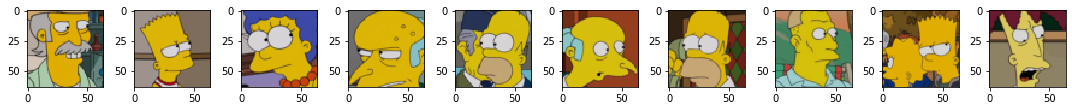

In [14]:
import re
import imageio

images = []

for filename in glob( INPUT_DATA_DIR + '*'):
  if re.search("\.(jpg|jpeg|png|bmp|tiff)$", filename):
    image = imageio.imread(filename, pilmode="RGB")
    image_resized = misc.imresize(image, (64, 64))
    images.append(np.array(image_resized))

images = np.array(images) / 255
print ("Input: " + str(images.shape))

np.random.shuffle(images)


sample_images = random.sample(list(images), SAMPLES_TO_SHOW)
show_samples(sample_images, OUTPUT_DIR + "inputs", 0)


In [0]:
# Adversarial networks ground truths for fake and valid arrays
valid = np.ones((BATCH_SIZE, 1))
fake = np.zeros((BATCH_SIZE, 1))

r, c = 4, 4
noise = np.random.normal(0, 1, (r*c, NOISE_SIZE))

In [16]:
#calculate steps per epoch
steps_per_epoch = 153 #    #Initially used a smaller number to get more epochs, but ideally this should be number of images divided by BATCH_SIZE (roughly 153)
print("Total epochs: {}, steps per epoch: {}".format(EPOCHS, steps_per_epoch))
steps_list = [x for x in range(steps_per_epoch)]

Training begins... Total epochs: 300, steps per epoch: 153


  0%|          | 0/300 [00:00<?, ?it/s]



Epoch: 1/300 | Step: 1/153 [D loss: 1.1292, acc.: 28.91%] [G loss: 1.4056]
Epoch: 1/300 | Step: 2/153 [D loss: 2.6423, acc.: 49.22%] [G loss: 0.5639]
Epoch: 1/300 | Step: 3/153 [D loss: 1.8046, acc.: 45.31%] [G loss: 1.6071]
Epoch: 1/300 | Step: 4/153 [D loss: 1.3111, acc.: 32.03%] [G loss: 2.2410]
Epoch: 1/300 | Step: 5/153 [D loss: 1.4969, acc.: 25.00%] [G loss: 3.4079]
Epoch: 1/300 | Step: 6/153 [D loss: 1.0005, acc.: 49.22%] [G loss: 3.8872]
Epoch: 1/300 | Step: 7/153 [D loss: 1.2325, acc.: 36.72%] [G loss: 5.0298]
Epoch: 1/300 | Step: 8/153 [D loss: 0.5814, acc.: 73.44%] [G loss: 2.6109]
Epoch: 1/300 | Step: 9/153 [D loss: 0.4811, acc.: 82.03%] [G loss: 2.6807]
Epoch: 1/300 | Step: 10/153 [D loss: 0.6239, acc.: 63.28%] [G loss: 4.5933]
Epoch: 1/300 | Step: 11/153 [D loss: 0.4504, acc.: 82.03%] [G loss: 3.8484]
Epoch: 1/300 | Step: 12/153 [D loss: 0.1814, acc.: 93.75%] [G loss: 2.0303]
Epoch: 1/300 | Step: 13/153 [D loss: 1.0566, acc.: 43.75%] [G loss: 10.1357]
Epoch: 1/300 | Ste

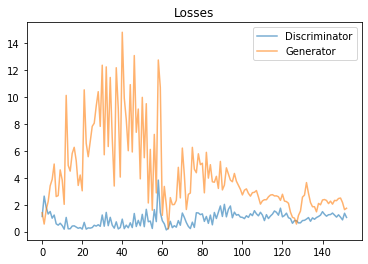

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

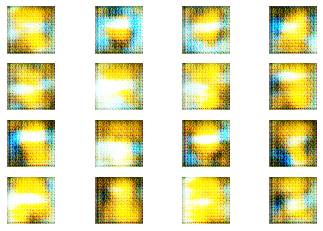

  0%|          | 1/300 [2:52:19<858:45:17, 10339.52s/it]

Epoch: 2/300 | Step: 1/153 [D loss: 1.2205, acc.: 29.69%] [G loss: 1.9641]
Epoch: 2/300 | Step: 2/153 [D loss: 1.1048, acc.: 37.50%] [G loss: 2.0381]
Epoch: 2/300 | Step: 3/153 [D loss: 1.6558, acc.: 17.19%] [G loss: 2.1047]
Epoch: 2/300 | Step: 4/153 [D loss: 1.1604, acc.: 32.81%] [G loss: 2.3531]
Epoch: 2/300 | Step: 5/153 [D loss: 1.2565, acc.: 34.38%] [G loss: 1.5369]
Epoch: 2/300 | Step: 6/153 [D loss: 1.2878, acc.: 26.56%] [G loss: 1.5078]
Epoch: 2/300 | Step: 7/153 [D loss: 0.9043, acc.: 55.47%] [G loss: 1.1535]
Epoch: 2/300 | Step: 8/153 [D loss: 1.1371, acc.: 32.81%] [G loss: 1.5133]
Epoch: 2/300 | Step: 9/153 [D loss: 1.2541, acc.: 28.12%] [G loss: 2.2544]
Epoch: 2/300 | Step: 10/153 [D loss: 1.2511, acc.: 23.44%] [G loss: 2.3601]
Epoch: 2/300 | Step: 11/153 [D loss: 1.2096, acc.: 32.81%] [G loss: 2.1419]
Epoch: 2/300 | Step: 12/153 [D loss: 1.0202, acc.: 39.84%] [G loss: 1.6800]
Epoch: 2/300 | Step: 13/153 [D loss: 0.9635, acc.: 41.41%] [G loss: 1.4532]
Epoch: 2/300 | Step: 

In [0]:
warnings.filterwarnings("ignore")
from tqdm import tqdm

d_loss_list = []
g_loss_list = []

for epoch in tqdm(range(EPOCHS)):
    epoch += 1  
    
    for step in range(steps_per_epoch):
        step +=1 
        #  Training the Discriminator
        # Select a half of images randomly
        idx = np.random.randint(0, images.shape[0], BATCH_SIZE)
        imgs = images[idx]

        # Sample noise and generate a batch of new images
        noise = np.random.normal(0, 1, (BATCH_SIZE, NOISE_SIZE))
        gen_imgs = model_generator.predict(noise)


        # Training the discriminator  with real and fake
        d_loss_real = model_discriminator.train_on_batch(imgs, valid)
        d_loss_fake = model_discriminator.train_on_batch(gen_imgs, fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        #  Train GAN
        # Train the generator to check for discriminator to mistake images as real or not
        g_loss = gan.train_on_batch(noise, valid)

        # Plot the progress
        print ("Epoch: {}/{} | Step: {}/{} [D loss: {:.4f}, acc.: {:.2f}%] [G loss: {:.4f}]".format(
                    epoch, EPOCHS, step, steps_per_epoch, d_loss[0], 100*d_loss[1], g_loss
                ))

        # Append discriminator loss, generator  loss lists

        d_loss_zero = d_loss[0]

        d_loss_list.append(d_loss_zero)
        g_loss_list.append(g_loss)


  # Plotting Loss for both discriminator and generator
    summarize_epoch(d_loss_list,g_loss_list)

    # Plotting the images
    gen_imgs = model_generator.predict(noise)

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(gen_imgs[cnt, :, :, :])
            axs[i,j].axis('off')
            cnt += 1
    plt.show()
    plt.close()
  
    if epoch % 10 == 0:
        model_generator.save("g{}.h5".format(epoch))